In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#den oberen Teil kennt man schon vom letzten Mal...
#Theano kommt neu dazu - 
#Library für effiziente Berechnungen mit großen Matrizen -> DeepLearning!
import theano 
import tensorflow

 
#Jetzt noch scikit-learn:
#hier stecken viele Funktionalitäten drin, die man gut brauchen kann: 
#Fehlerfunktionen, Standard-Modelltypen, Preprocessing-Algorithmen, Daten... 

import sklearn as sl 
from sklearn import model_selection, metrics, datasets
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

#wichtige Keras Funktionalitäten

import keras
from keras import layers
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Activation
from keras import regularizers
from keras.models import Sequential
from keras import backend as K

from keras.optimizers import SGD, Adadelta, Adagrad, RMSprop #Stochastic Gradient Descent

from keras.utils import to_categorical

from matplotlib import pyplot as plt
from IPython.display import clear_output
#

Using TensorFlow backend.


## Vordefinierte Funktion um den Fehler während des Trainings zu beobachten

In [2]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

## Import der MNIST Daten in kompakter Form - Quelle Keras datasets

In [3]:
import gzip
import pickle
f = gzip.open('../Daten/mnist.pkl.gz', 'rb')
#if sys.version_info < (3,):
#data = pickle.load(f)
#else:
data = pickle.load(f, encoding='bytes')
f.close()
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = data


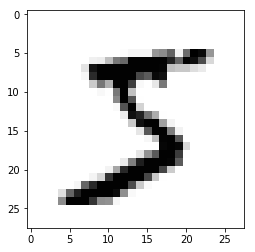

In [4]:
#plotte das erste Bild

plt.imshow(x_train_orig[0], cmap='Greys', interpolation = 'None'); #plotten

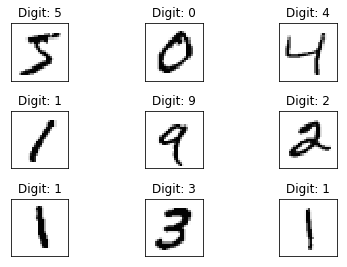

In [5]:
#ein paar zusätzliche Beispiele

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train_orig[i], cmap='Greys', interpolation = 'None')
  plt.title("Digit: {}".format(y_train_orig[i]))
  plt.xticks([])
  plt.yticks([])


In [6]:
#checke die shape der Bilder
x_train_orig[0].shape

(28, 28)

In [7]:
#We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train_AE = x_train_orig.astype('float32') / 255.
x_test_AE = x_test_orig.astype('float32') / 255.
x_train_AE = x_train_AE.reshape((len(x_train_AE), np.prod(x_train_AE.shape[1:])))
x_test_AE = x_test_AE.reshape((len(x_test_AE), np.prod(x_test_AE.shape[1:])))

print(x_train_AE.shape)
print(x_test_AE.shape)

(60000, 784)
(10000, 784)


### Das CNN-Modell erwartet Daten in der Form:
(Anzahl Datenpunkte, Höhe, Breite,Kanäle)  
dabei ist die Anzahl der Kanäle z.B. 1 für Graustufen oder 3 für RGB-Bilder  

In [8]:
#reshape
x_train_unnorm = x_train_orig.reshape(60000,28,28,1)
x_test_unnorm = x_test_orig.reshape(10000,28,28,1)

#check image shape
x_train_unnorm[0].shape

#Die Daten sind noch nicht im richtigen Wertebereich.  
#MaxNorm reicht hier aus, weil die Einträge nur positiv sind...

print(x_train_unnorm[0].max())
print(x_test_unnorm[0].max())


x_train=x_train_unnorm/255
x_test=x_test_unnorm/255

print(x_train[0].max())
print(x_test[0].max())

#Das Target muß noch OneHot-kodiert werden

#one-hot encode target column
y_train = to_categorical(y_train_orig)
y_test = to_categorical(y_test_orig)
print(y_train_orig[0])
print(y_train[0])

255
255
1.0
1.0
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Erster einfacher linearer Autoencoder

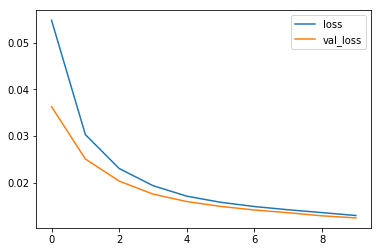

10000/10000 [==============================] - 0s 13us/step


[0.012414402453601361, 0.03559746593236923]

In [9]:
AE_linear = Sequential()

AE_linear.add(Dense(196, activation='relu',input_dim=784)) #Dimension ist zugleich Dim-Kompression
AE_linear.add(Dense(784, activation='relu')) #Ausgabe muß Dim Input besitzen (Rekonstruktion)

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...
AE_linear.compile(loss='mse',
              optimizer=sgd,
              metrics=['mean_absolute_error'])

AE_linear.fit(x_train_AE, x_train_AE, #Target = Input!!
          epochs=10,
          batch_size=100,
          verbose=1, 
          callbacks=[plot_losses],
          validation_data=(x_test_AE, x_test_AE))
score = AE_linear.evaluate(x_test_AE, x_test_AE, batch_size=128)
score

In [10]:
decoded_imgs_AE = AE_linear.predict(x_test_AE)

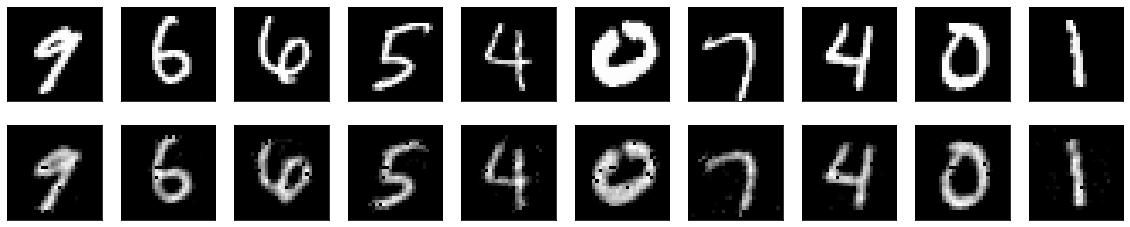

In [11]:
n = 10  # how many digits we will display
fig=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_AE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_AE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Vielleicht möchte man auch wissen, wie der komprimierte Datensatz aussieht.
Dazu braucht man einen Trick!

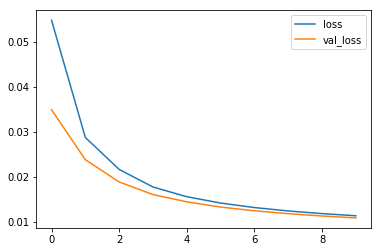

10000/10000 [==============================] - 0s 13us/step


[0.010837418422102929, 0.03437498211860657]

In [12]:
AE_linear = Sequential()

l1=layers.Dense(196, activation='relu',input_dim=784) #definiere die erste Schicht
l2=layers.Dense(784, activation='relu') #definiere die zweite Schicht

AE_linear.add(l1) #erstes Modell verbindet l1 und l2 und wird trainiert
AE_linear.add(l2)

#definiere ein "Hilfsmodell": nur die Zwischenschicht wird hier angelegt und zwar als Output
#Das Modell wird auch nicht trainiert sondern nur zum "recall" verwendet!

AE_linear_2=Sequential() #zweites Modell ist ein Hilfsmittel
AE_linear_2.add(l1) #es besteht nur aus der Hidden-Schicht von Modell 1

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...
AE_linear.compile(loss='mse',
              optimizer=sgd,
              metrics=['mean_absolute_error'])

AE_linear.fit(x_train_AE, x_train_AE,
          epochs=10,
          batch_size=100,
          verbose=1, 
          callbacks=[plot_losses],
          validation_data=(x_test_AE, x_test_AE))
score = AE_linear.evaluate(x_test_AE, x_test_AE, batch_size=128)
score

In [13]:
encoded_imgs_AE = AE_linear_2.predict(x_test_AE)
decoded_imgs_AE = AE_linear.predict(x_test_AE)

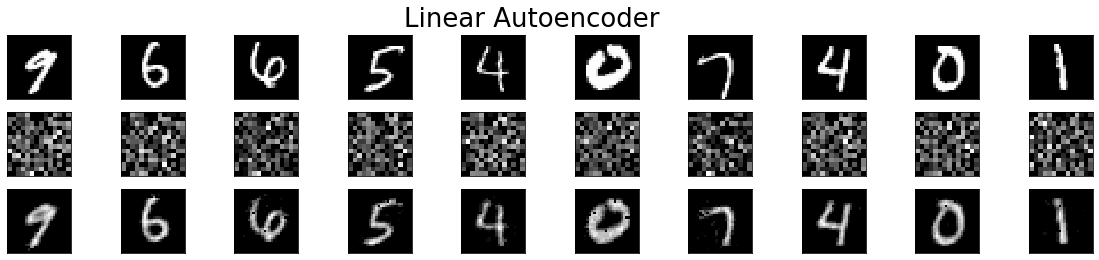

In [14]:
n = 10  # how many digits we will display
fig=plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_AE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display encoding
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs_AE[i+20].reshape(14, 14))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_AE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig.suptitle('Linear Autoencoder', size=26)
plt.show()

## Das Ergebnis ist noch nicht so überzeugend! Wir brauchen Nicht-Linearität!!!!

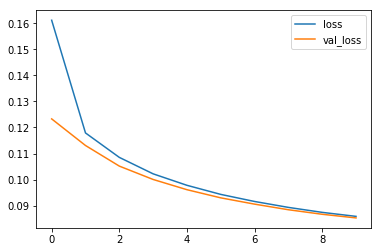

10000/10000 [==============================] - 0s 13us/step


[0.08529723806381226, 0.08529724180698395]

In [15]:
AE_nonlinear = Sequential()

ll1=layers.Dense(196, activation='relu',input_dim=784) #sigmoid statt relu!!
ll2=layers.Dense(784, activation='sigmoid') #sigmoid statt relu

AE_nonlinear.add(ll1) #erstes Modell verbindet l1 und l2 und wird trainiert
AE_nonlinear.add(ll2)

#definiere ein "Hilfsmodell": nur die Zwischenschicht wird hier angelegt und zwar als Output
#Das Modell wird auch nicht trainiert sondern nur zum "recall" verwendet!

AE_nonlinear_2=Sequential() #zweites Modell ist ein Hilfsmittel
AE_nonlinear_2.add(ll1) #es besteht nur aus der Hidden-Schicht von Modell 1

sgd = SGD(lr=0.1,  momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...
myadadelta=Adadelta(learning_rate=0.5, rho=0.95)

AE_nonlinear.compile(loss='mae', #auch möglich binary_crossentropy, ...
              optimizer='adadelta', #auch möglich sgd, RMSprop
              metrics=['mean_absolute_error'])

AE_nonlinear.fit(x_train_AE, x_train_AE,
          epochs=10,
          batch_size=100,
          verbose=1, 
          callbacks=[plot_losses],
          validation_data=(x_test_AE, x_test_AE))
score = AE_nonlinear.evaluate(x_test_AE, x_test_AE, batch_size=128)
score

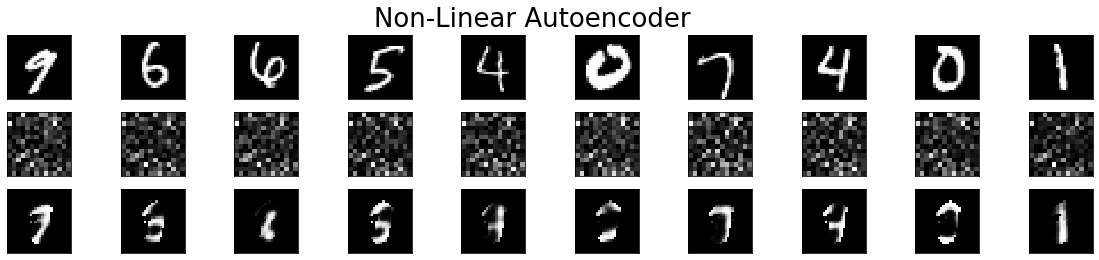

In [16]:
encoded_imgs_nlAE = AE_nonlinear_2.predict(x_test_AE)
decoded_imgs_nlAE = AE_nonlinear.predict(x_test_AE)

n = 10  # how many digits we will display
fig=plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_AE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoding
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs_nlAE[i+20].reshape(14, 14)) #reshape auf quadratisches Bild
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_nlAE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig.suptitle('Non-Linear Autoencoder', size=26)
plt.show()

## Aufgabe 1)

- Ist der nicht-lineare Autoencoder besser als der lineare?
- Untersuchen Sie, welche Einflußfaktoren (Meta-Parameter) zur Verbesserung der Performanz beitragen. 
- Untersuchen Sie für das beste Modell ab welcher Kompression (= Dim(Hid1)) die Dekompression nicht mehr gelingt.


## Aufgabe 2)

Unten finden Sie eine Variante, wie ein einfacher Deep-Autoencoder aufgebaut sein könnte.

- Versuchen Sie das Netz schrittweise komplexer zu getalten.  
- Orientieren Sie sich beim Vergleich der Performance am MAE (ungefähr 0.05) des einfachen nicht-linearen Autoencoders.  
- Helfen Dropout-Schichten zur Regularisierung?
- Läßt sich das Netz auch ohne weitere Stabilisierung erfolgreich trainieren?


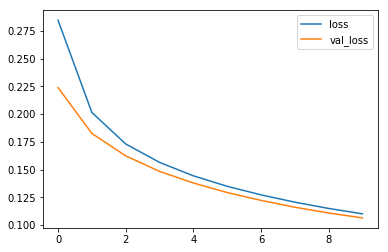

10000/10000 [==============================] - 0s 25us/step


[0.10628694336414338, 0.04565685987472534]

In [17]:
DeepAE_nonlinear = Sequential()

dl1=layers.Dense(100, activation='relu',input_dim=784) #sigmoid statt relu!!
#d1=layers.Dropout(0.5)
#dl2=layers.Dense(36, activation='sigmoid') #sigmoid statt relu
#dl3=layers.Dense(100, activation='sigmoid') #sigmoid statt relu
#d2=layers.Dropout(0.5)
dl4=layers.Dense(784, activation='sigmoid') 

DeepAE_nonlinear.add(dl1) #erstes Modell verbindet l1 und l2 und wird trainiert
#DeepAE_nonlinear.add(d1)
#DeepAE_nonlinear.add(dl2)
#DeepAE_nonlinear.add(dl3)
#DeepAE_nonlinear.add(d2)
DeepAE_nonlinear.add(dl4)

#definiere ein "Hilfsmodell": nur die Zwischenschicht wird hier angelegt und zwar als Output
#Das Modell wird auch nicht trainiert sondern nur zum "recall" verwendet!

DeepAE_nonlinear_2=Sequential() #zweites Modell ist ein Hilfsmittel
DeepAE_nonlinear_2.add(dl1) #es besteht nur aus der Hidden-Schicht von Modell 1
#DeepAE_nonlinear_2.add(d1)
#DeepAE_nonlinear_2.add(dl2)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...
myadadelta=Adadelta(learning_rate=1, rho=0.95)

DeepAE_nonlinear.compile(loss='binary_crossentropy',
        optimizer=myadadelta,
        metrics=['mean_absolute_error'])

DeepAE_nonlinear.fit(x_train_AE, x_train_AE,
        epochs=10,
        batch_size=100,
        verbose=1, 
        callbacks=[plot_losses],
        validation_data=(x_test_AE, x_test_AE))
score = DeepAE_nonlinear.evaluate(x_test_AE, x_test_AE, batch_size=128)
score

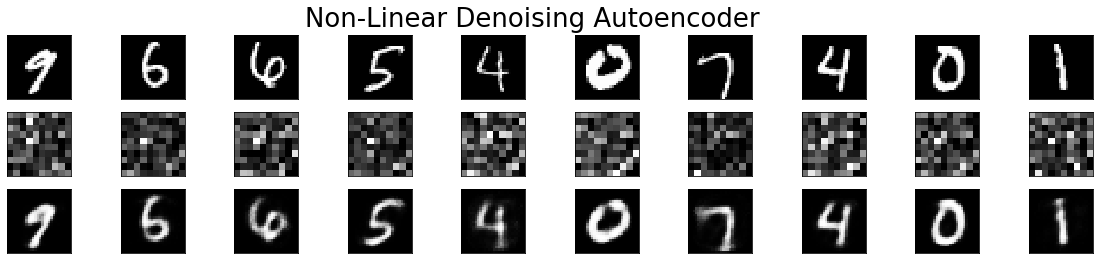

In [18]:
encoded_imgs_nlDeepAE = DeepAE_nonlinear_2.predict(x_test_AE)
decoded_imgs_nlDeepAE = DeepAE_nonlinear.predict(x_test_AE)

n = 10  # how many digits we will display
fig=plt.figure(figsize=(20, 4))
for i in range(n):
    # display noisy original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_AE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoding
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs_nlDeepAE[i+20].reshape(10, 10)) #reshape auf quadratisches Bild
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_nlDeepAE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig.suptitle('Non-Linear Denoising Autoencoder', size=26)
plt.show()

# Denoising Autoencoder - Entrauschen von Daten

Es ist ganz einfach einen Denoising Autoencoder zu basteln.  
Wir brauchen dazu nur einen verrauschten Input um den Autoencoder zu trainieren...  
Ansonsten bleibt die Struktur gleich.

In [19]:

noise_factor = 0.5 #Stärke des Rausch-Signales
x_train_noisy = x_train_AE + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_AE.shape) 
x_test_noisy = x_test_AE + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_AE.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train_noisy.shape)
print(x_test_noisy.shape)




(60000, 784)
(10000, 784)


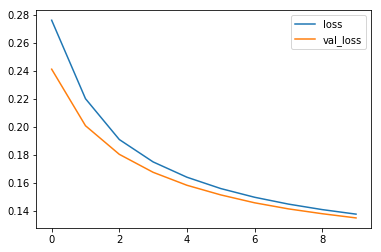

10000/10000 [==============================] - 0s 22us/step


[0.13488049962520599, 0.06460391730070114]

In [20]:
DAE_nonlinear = Sequential()

lll1=layers.Dense(196, activation='relu',input_dim=784) #sigmoid statt relu!!
lll2=layers.Dense(784, activation='sigmoid') #sigmoid statt relu

DAE_nonlinear.add(lll1) #erstes Modell verbindet l1 und l2 und wird trainiert
DAE_nonlinear.add(lll2)

#definiere ein "Hilfsmodell": nur die Zwischenschicht wird hier angelegt und zwar als Output
#Das Modell wird auch nicht trainiert sondern nur zum "recall" verwendet!

DAE_nonlinear_2=Sequential() #zweites Modell ist ein Hilfsmittel
DAE_nonlinear_2.add(lll1) #es besteht nur aus der Hidden-Schicht von Modell 1

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...
myadadelta=Adadelta(learning_rate=0.5, rho=0.95)

DAE_nonlinear.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['mean_absolute_error'])

DAE_nonlinear.fit(x_train_noisy, x_train_AE, #Input sind Daten+Noise, Target ist Daten OHNE Noise
          epochs=10,
          batch_size=100,
          verbose=1, 
          callbacks=[plot_losses],
          validation_data=(x_test_noisy, x_test_AE))
score = DAE_nonlinear.evaluate(x_test_noisy, x_test_AE, batch_size=128)
score

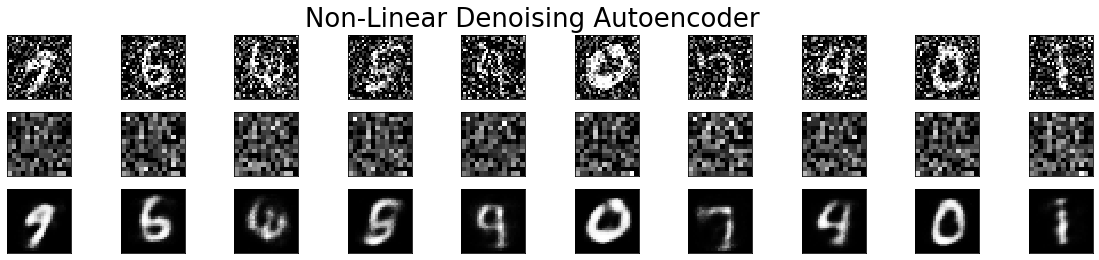

In [21]:
encoded_imgs_nlDAE = DAE_nonlinear_2.predict(x_test_noisy)
decoded_imgs_nlDAE = DAE_nonlinear.predict(x_test_noisy)

n = 10  # how many digits we will display
fig=plt.figure(figsize=(20, 4))
for i in range(n):
    # display noisy original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoding
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs_nlDAE[i+20].reshape(14, 14))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_nlDAE[i+20].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig.suptitle('Non-Linear Denoising Autoencoder', size=26)
plt.show()

## Aufgabe 2)

Untersuchen Sie den Denoising Autoencoder!  

- Welche Performanz hat das Modell im Vergleich zu dem mit den unverrauschten Input-Daten? Wieso sieht man, was man sieht? :-)
- wieviel Rauschen verträgt das Netz ohne Änderung der Konfiguration, wenn der Output noch lesbar sein soll?
- Welche Parameter muß man bei gleicher Kompression anpassen, wenn das Rauschen stärker wird?
- Wie schneidet das Netz ab, wenn die UNGESTÖRTEN Test-Daten als Input gegeben werden?
- Wie muß ein Netz aussehen, das NUR zum Entfernen von Störsignalen verwendet werden soll?


# Zeitreihen - Modellierung von Regressionsproblemen

Wir haben schon am Beispiel der Immo-Daten ein Regressionsproblem untersucht.  
Allerdings waren die Daten "ungeordnet", d.h. ohne innere Ordnung wie das im Beispiel von Zeitreihen der Fall ist. Für die Modellierung hatte das einige (wenige) Konsequenzen:  

Im Vergleich zu Klassifikationsaufgaben mußten für ein standard MLP nur die Fehlerfunktion (loss) und die Aktivierung der Output-Schicht angepaßt werden.  
Bei Zeitreihen ist das Ganze nicht mehr so einfach...

Hier jetzt unterschiedliche Modelle zur Zeitreihenprognose an einem Mini-Beispiel.  

Daten: AirPassengersPlusTimeLag.csv

In [22]:
APPTL_DF = pd.read_csv('../Daten/AirPassengersPlusTimeLag.csv')
APPTL_DF.head()

,Year,Month,NrOfPassengers,NrOfPassengers(t-1),NrOfPassengers(t-2),NrOfPassengers(t-3),NrOfPassengers(t-4),NrOfPassengers(t-5),NrOfPassengers(t-6)
0,1949,1,112,NaN,NaN,NaN,NaN,NaN,NaN
1,1949,2,118,112.0,NaN,NaN,NaN,NaN,NaN
2,1949,3,132,118.0,112.0,NaN,NaN,NaN,NaN
3,1949,4,129,132.0,118.0,112.0,NaN,NaN,NaN
4,1949,5,121,129.0,132.0,118.0,112.0,NaN,NaN


Die Daten bestehen aus Jahr, Monat und Zielgröße.  
In den weiteren Spalten stehen die Passagierzahlen mit einem bestimmten Time-Lag...

Der erste vollständige Datenpunkt ist an Position 7 zu finden!

In [23]:
APPTL_array=np.array(APPTL_DF, dtype=np.float64) #Numpy array draus machen
APPTL=APPTL_array[7:] #Zeilen mit NaN entfernen

print(APPTL_array.shape)
print(APPTL.shape)

(144, 9)
(137, 9)


In [24]:
#alle Einträge der zweiten Spalte d.h. Passagierzahlen
#das wird das target, das wir später zum Lernen benutzen wollen 
AirPassengersTarget = APPTL[:,2].reshape(-1,1)

print(AirPassengersTarget)

[[148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]
 [472.]
 [548.]
 [559.]
 [463.]
 [407.]
 [362.]
 [405.]


In [25]:
#die Inputs sind alle Werte der Tabelle #aber ohne die zweite Spalte
#da stand ja das target drin
AirPassengersInput=np.delete(APPTL, 2, 1) 
print(AirPassengersInput[0])
 
     

[1949.    8.  148.  135.  121.  129.  132.  118.]


# # $\textbf{Achtung:}$ Die Daten müssen noch normalisiert werden!!

In [26]:

from sklearn.preprocessing import MinMaxScaler

minmax_scale1=MinMaxScaler(feature_range=(-1,1)) #range -1,1 falls tanh 
minmax_scale2=MinMaxScaler(feature_range=(-1,1)) #range -1,1 falls tanh

TargetTransformed=minmax_scale1.fit_transform(AirPassengersTarget)
InputTransformed=minmax_scale2.fit_transform(AirPassengersInput)
InputTransformed.shape

(137, 8)

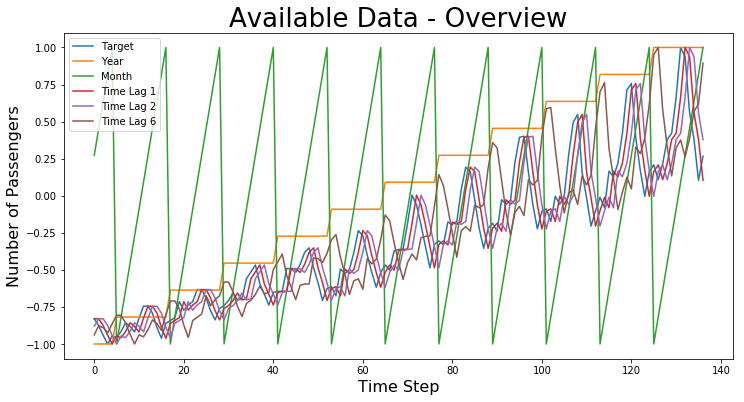

In [27]:
#plt.plot(AirPassengersTarget)
fig=plt.figure(figsize=(12, 6))
plt.plot(TargetTransformed,label="Target")
plt.plot(InputTransformed[:,0],label="Year") 
plt.plot(InputTransformed[:,1],label="Month")
plt.plot(InputTransformed[:,2],label="Time Lag 1") 
plt.plot(InputTransformed[:,3],label="Time Lag 2")
plt.plot(InputTransformed[:,7],label="Time Lag 6")
plt.legend(loc='upper left');
plt.ylabel('Number of Passengers', size=16) 
plt.xlabel('Time Step', size=16)
plt.title('Available Data - Overview', size=26)
plt.show()

## Split in Training und Testmenge

In [28]:
print(int(len(AirPassengersTarget)*0.8)) #Anzahl der Datenpunkte für 80% Trainingsmenge
print(len(AirPassengersInput))

109
137


In [29]:
#split in Training und Test Sets
#Gesamtlänge
total_size = len(AirPassengersTarget)
#85% Training
train_size = int(len(AirPassengersTarget) * 0.8) #Rest Validierungsmenge
test_size = len(AirPassengersTarget) - train_size
#Targets für Training und Vali
TargetTrain = TargetTransformed[0:train_size,:] 
TargetTest = TargetTransformed[train_size:total_size,:]
#Inputs für Training und Vali
AllInputTrain = InputTransformed[0:train_size,:] 
AllInputTest = InputTransformed[train_size:total_size,:]
#Größencheck
print(len(TargetTrain), len(TargetTest)) 
print(len(AllInputTrain), len(AllInputTest))
                 
print(AllInputTrain.shape)                               

109 28
109 28
(109, 8)


In [30]:
#ein minimales Setup wäre es, nur
#die Kalenderinfos als Input zu berücksichtigen
#Das ist auch insofern günstig, weil diese Info beliebig
#weit in die Zukunft voraus verfügbar ist 
#das erlaubt maximal lange Prognosen...

CalendarInputTrain = np.delete(AllInputTrain,[2,3,4,5,6,7],1) 
CalendarInputTest = np.delete(AllInputTest,[2,3,4,5,6,7],1)

print(AllInputTrain[0]) 
print(CalendarInputTrain[0])

[-1.          0.27272727 -0.83011583 -0.88030888 -0.93436293 -0.9034749
 -0.89189189 -0.93846154]
[-1.          0.27272727]


# Einfachstes Setup: 3-Layer MLP

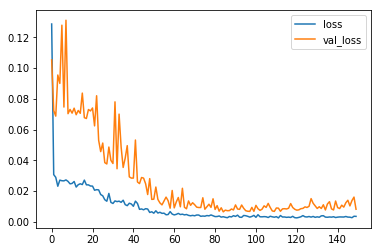

28/28 [==============================] - 0s 607us/step


[0.008237732742307864, 0.0769503265619278]

In [52]:
MLP_CalendarInput = Sequential()
MLP_CalendarInput.add(Dense(100 , activation='tanh', input_dim=2))
MLP_CalendarInput.add(Dense(100 , activation='tanh'))
MLP_CalendarInput.add(Dense(1 , activation='linear'))


sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...
myadadelta=Adadelta(learning_rate=0.5, rho=0.95)

MLP_CalendarInput.compile(loss='mse',
              optimizer=sgd,
              metrics=['mean_absolute_error'])

MLP_CalendarInput.fit(CalendarInputTrain, TargetTrain, #Input sind Kalenderinfos, Target ist die Passagierzahl
          epochs=150,
          batch_size=10,
          verbose=1, 
          callbacks=[plot_losses],
          validation_data=(CalendarInputTest,TargetTest))
score = MLP_CalendarInput.evaluate(CalendarInputTest,TargetTest, batch_size=1)
score

In [53]:
MLP_target_predicted1 = MLP_CalendarInput.predict(CalendarInputTest) 
MLP_target_training1 = MLP_CalendarInput.predict(CalendarInputTrain)

#am besten transformiert man die Daten in den original Wertebereich 
#das ist für die Auswertung günstiger

MLP_target_predicted_rescaled1 = minmax_scale1.inverse_transform(MLP_target_predicted1.reshape(-1,1))
MLP_target_training_rescaled1 = minmax_scale1.inverse_transform(MLP_target_training1.reshape(-1,1))
TargetTrain_rescaled = minmax_scale1.inverse_transform(TargetTrain.reshape(-1,1)) 
TargetTest_rescaled = minmax_scale1.inverse_transform(TargetTest.reshape(-1,1))


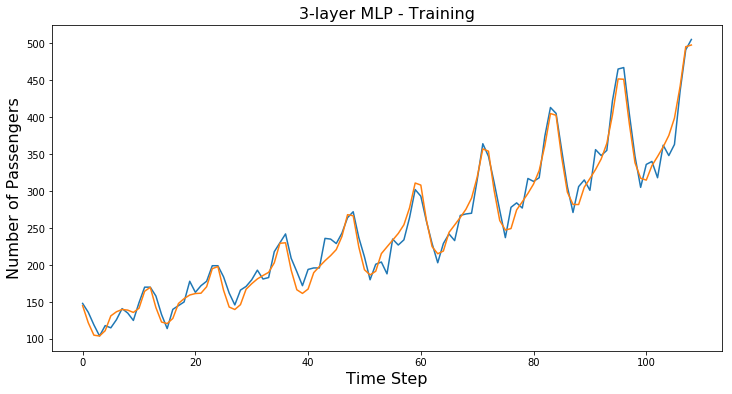

In [54]:
fig=plt.figure(figsize=(12, 6))
plt.plot(TargetTrain_rescaled) 
plt.plot(MLP_target_training_rescaled1)
plt.ylabel('Number of Passengers', size=16)
plt.xlabel('Time Step', size=16) 
plt.title('3-layer MLP - Training', size=16)
plt.show()

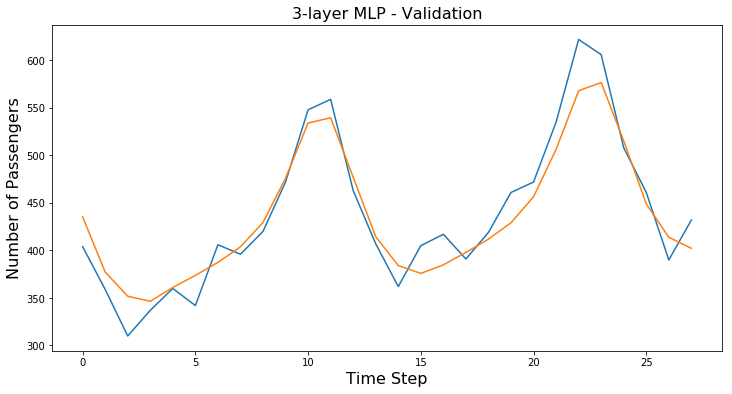

In [55]:
fig=plt.figure(figsize=(12, 6))
plt.plot(TargetTest_rescaled)
plt.plot(MLP_target_predicted_rescaled1)
plt.ylabel('Number of Passengers', size=16)
plt.xlabel('Time Step', size=16) 
plt.title('3-layer MLP - Validation', size=16)
plt.show()

...jetzt mal Information der letzten vergangenen 3 Monate mit berücksichtigen  
-> Dimension des Inputs ist Jahr + Monat + 3TimeLags =5

In [56]:
InputLag3Train = np.delete(AllInputTrain,[5,6,7],1) 
InputLag3Test = np.delete(AllInputTest,[5,6,7],1)

#TargetTrain.shape
#InputLag3Train.shape

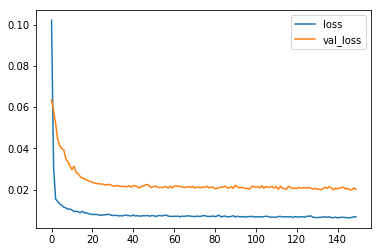

28/28 [==============================] - 0s 150us/step


[0.02023934619501233, 0.11626548320055008]

In [57]:
MLP_Lag3Input = Sequential()
MLP_Lag3Input.add(Dense(100 , activation='tanh', input_dim=5))
MLP_Lag3Input.add(Dense(100 , activation='tanh'))
MLP_Lag3Input.add(Dense(1 , activation='linear'))


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...
myadadelta=Adadelta(learning_rate=0.5, rho=0.95)

MLP_Lag3Input.compile(loss='mse',
              optimizer=sgd,
              metrics=['mean_absolute_error'])

MLP_Lag3Input.fit(InputLag3Train, TargetTrain, #Input sind Daten+Noise, Target ist Daten OHNE Noise
          epochs=150,
          batch_size=10,
          verbose=1, 
          callbacks=[plot_losses],
          validation_data=(InputLag3Test,TargetTest))
score = MLP_Lag3Input.evaluate(InputLag3Test,TargetTest, batch_size=10)
score

In [58]:
MLPLag3_target_predicted1 = MLP_Lag3Input.predict(InputLag3Test) 
MLPLag3_target_training1 = MLP_Lag3Input.predict(InputLag3Train)

#am besten transformiert man die Daten in den original Wertebereich 
#das ist für die Auswertung günstiger

MLPLag3_target_predicted_rescaled1 = minmax_scale1.inverse_transform(MLPLag3_target_predicted1.reshape(-1,1))
MLPLag3_target_training_rescaled1 = minmax_scale1.inverse_transform(MLPLag3_target_training1.reshape(-1,1))
TargetTrain_rescaled = minmax_scale1.inverse_transform(TargetTrain.reshape(-1,1)) 
TargetTest_rescaled = minmax_scale1.inverse_transform(TargetTest.reshape(-1,1))



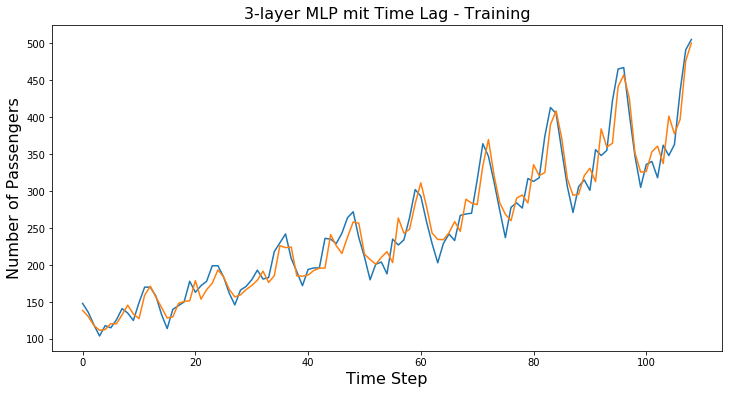

In [59]:
fig=plt.figure(figsize=(12, 6))
plt.plot(TargetTrain_rescaled) 
plt.plot(MLPLag3_target_training_rescaled1)
plt.ylabel('Number of Passengers', size=16)
plt.xlabel('Time Step', size=16) 
plt.title('3-layer MLP mit Time Lag - Training', size=16)
plt.show()

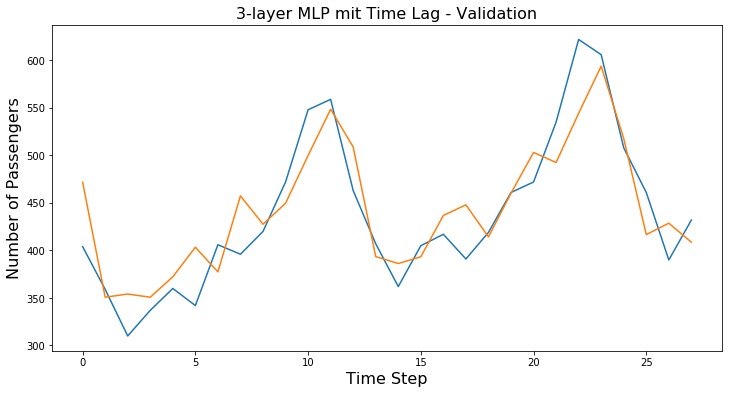

In [60]:
fig=plt.figure(figsize=(12, 6))
plt.plot(TargetTest_rescaled)
plt.plot(MLPLag3_target_predicted_rescaled1)
plt.ylabel('Number of Passengers', size=16)
plt.xlabel('Time Step', size=16) 
plt.title('3-layer MLP mit Time Lag - Validation', size=16)
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
           
rmse1 = sqrt(mean_squared_error(TargetTest_rescaled, MLP_target_predicted_rescaled1))
rmse2 = sqrt(mean_squared_error(TargetTest_rescaled, MLPLag3_target_predicted_rescaled1))
mae1 = mean_absolute_error(TargetTest_rescaled, MLP_target_predicted_rescaled1) 
mae2 = mean_absolute_error(TargetTest_rescaled, MLPLag3_target_predicted_rescaled1)
r2score1 = r2_score(TargetTest_rescaled, MLP_target_predicted_rescaled1) #Korrelation
r2score2 = r2_score(TargetTest_rescaled, MLPLag3_target_predicted_rescaled1) #Korrelation
print ('RMSE1:',rmse1)
print('RMSE2:' ,rmse2) 
print ('MAE1:',mae1)
print('MAE2:', mae2)
print ('r2Score1:',r2score1)
print('r2Score2:', r2score2)

RMSE1: 23.507344006249905
RMSE2: 36.84665186756627
MAE1: 19.930137634277344
MAE2: 30.112762451171875
r2Score1: 0.9104051847038215
r2Score2: 0.7798737602041188


## Aufgabe 3)
Testen Sie, ob das Erweitern der Architektur die Performanz verbessert Bsp.:
- mehr Neuronen in der Hidden-Schicht
- zusätzliche Schichten einfügen
- anderes $\eta$ (Schrittweite) 
- BatchSize

## Aufgabe 4)

Wir haben den Anfangszeitraum fürs Training verwendet und den Test auf das Ende verlegt.  Frage ist jetzt: ändert es etwas an der Performanz, wenn man die Trainingsdaten zufällig aus der Gesamtmenge auswählt?  

Dann würde das Netz beim Trainieren auch die großen Werte am Ende mitbekommen... 

- Testen Sie, inwieweit sich durch eine andere Auswahl der Trainingsmenge das Problem noch besser darstellen läßt.


# Innovative Idee: Zeitreihenprognose mit einem CNN

Als Input können wir  

1) die 6 Time Lags oder  
2) den kompletten vorherigen Input nutzen...  

Wir lernen dann keine Klassifikation sondern ein Regressionsproblem.  
Das heißt: alles bleibt im Prinzip gleich außer der vollverschalteten Schicht am Ende.  
Hier benötigt man eine andere Aktivierung und eine andere Fehlerfunktion.  

In [62]:
#falls nur auf den Passagierdaten mit Time-Lag trainiert werden soll 
#muß die kalenderinfo raus... 
#ConvInputTrain=np.delete(AllInputTrain,[0,1],1) 
#ConvInputTest=np.delete(AllInputTest,[0,1],1)
ConvInputTrain=AllInputTrain 
ConvInputTest=AllInputTest
print (ConvInputTest.shape)

(28, 8)


In [63]:
#die CNNs benötigen einen Input in einer speziellen Struktur 
#Anzahl der Beispiele, Höhe und Breite, Anzahl der Kanäle 
#also hier (n,1,8,1)
#das erreicht man mit einem reshape
#falls die Struktur nicht stimmt geht gar nichts!

ConvInputTrain1=ConvInputTrain.reshape(109,1,8,1) 
#sonst 6 
ConvInputTest1=ConvInputTest.reshape(28,1,8,1) 
#sonst 6
print (ConvInputTrain1.shape) 
print (ConvInputTest1.shape)

(109, 1, 8, 1)
(28, 1, 8, 1)


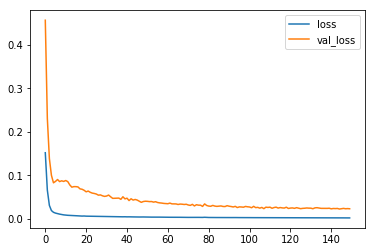

In [67]:
#create model
MediumSmallConvNNReg = Sequential()
#add model layers
MediumSmallConvNNReg.add(Conv2D(5,                       #Anzahl der Filter
                          kernel_size=(1,3),        #Dimensionen des Fensters
                          strides=(1,1),            #Größe der Schritte
                          padding='same',           #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',        #Aktivierungsfunktion
                          input_shape=(1,8,1)))    #Dimension des Inputs

MediumSmallConvNNReg.add(Conv2D(32, kernel_size=(1,3), 
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))        #Aktivierungsfunktion

MediumSmallConvNNReg.add(Flatten())                       #Feature-Vektor erzeugen
MediumSmallConvNNReg.add(Dense(1, activation='tanh')) #dicht verschaltete Schicht - lernt Klassifikation!

#from keras.utils import plot_model
#plot_model(MediumSmallConvNNReg, to_file='modelCNN_MNIST.png')

#compile model using accuracy to measure model performance

#myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#myRMSprop=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)


#Stochastic gradient descent
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...

MediumSmallConvNNReg.compile(
    optimizer=sgd, 
    loss='mse', 
    metrics=['mean_absolute_error'])

#train the model
MediumSmallConvNNRegHist=MediumSmallConvNNReg.fit(ConvInputTrain1, TargetTrain, 
          epochs=150,
          batch_size=10,
          verbose=1,
          validation_data=(ConvInputTest1, TargetTest),  
          callbacks=[plot_losses])

In [68]:
CNN_target_predicted1 = MediumSmallConvNNReg.predict(ConvInputTest1) 
CNN_target_training1 = MediumSmallConvNNReg.predict(ConvInputTrain1)

#am besten transformiert man die Daten in den original Wertebereich 
#das ist für die Auswertung günstiger

CNN_target_predicted_rescaled1 = minmax_scale1.inverse_transform(CNN_target_predicted1.reshape(-1,1))
CNN_target_training_rescaled1 = minmax_scale1.inverse_transform(CNN_target_training1.reshape(-1,1))
TargetTrain_rescaled = minmax_scale1.inverse_transform(TargetTrain.reshape(-1,1)) 
TargetTest_rescaled = minmax_scale1.inverse_transform(TargetTest.reshape(-1,1))



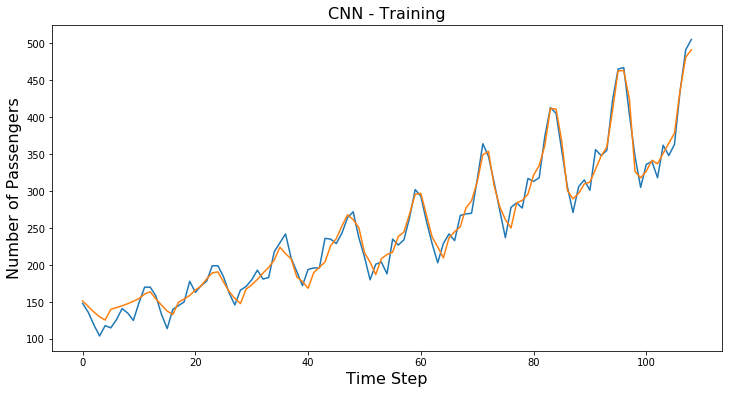

In [69]:
fig=plt.figure(figsize=(12, 6))
plt.plot(TargetTrain_rescaled) 
plt.plot(CNN_target_training_rescaled1)
plt.ylabel('Number of Passengers', size=16)
plt.xlabel('Time Step', size=16) 
plt.title('CNN - Training', size=16)
plt.show()

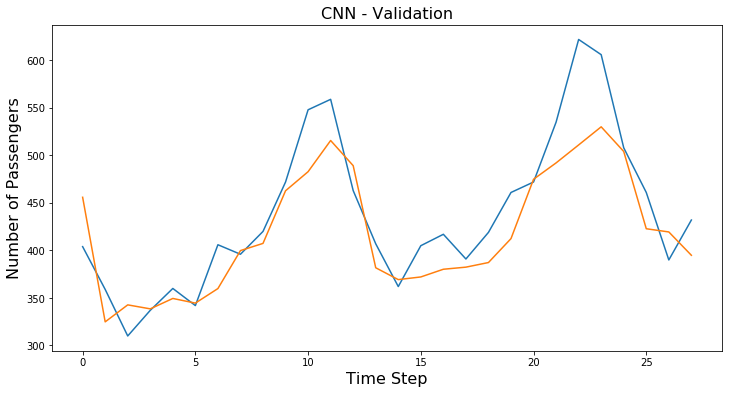

In [70]:
fig=plt.figure(figsize=(12, 6))
plt.plot(TargetTest_rescaled)
plt.plot(CNN_target_predicted_rescaled1)
plt.ylabel('Number of Passengers', size=16)
plt.xlabel('Time Step', size=16) 
plt.title('CNN - Validation', size=16)
plt.show()

## Aufgabe 5)

- Berechnen Sie die entsprechenden scores um die Performance des CNN-Modelles mit dem MLP vergleichen zu können.
- Testen Sie, ob man hier durch Fine-Tuning noch etwas erreichen kann.

- Erweitern Sie die Architektur, indem Sie noch zusätzliche Schichten einfügen (Pooling, Dropout etc.).
- Vergleichen Sie die erzielten Ergebnisse mit denen der anderen Modelle.

## Aufgabe 6)

Die Eingangsdaten haben einen starken Trend! Wir haben bereits diskutiert, daß NN-Modelle besser performen, wenn lineare Trends vor der Modellierung entfernt werden.

- Berechnen Sie trendbereinigte Daten
- Testen Sie die Performanz der Modelle für den neuen Datensatz.
